# HR Analytics: Understanding Employee Attrition
Analyzing trends and patterns in employee attrition using HR analytics data from Kaggle. The data is on Atlas Lab's employees. [HR Analytics Employee Attrition and Performance] (https://www.kaggle.com/datasets/mahmoudemadabdallah/hr-analytics-employee-attrition-and-performance/data)

## Objectives
- Understand the distribution of employee attributes (age, department, role, etc.)
- Explore patterns in employee attrition
- Analyze job and performance satisfaction metrics
- Identify factors correlated with attrition

In [36]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, normaltest, probplot
import os
import pandas as pd
from data_cleaning import clean_data
from univariate import ql_stats, qn_stats, dt_stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os


## Load and Clean Data
Load two datasets: **'employee.csv'** and **'performance.csv'**

In [22]:
df_employee = pd.read_csv('data/Employee.csv')
df_performance = pd.read_csv('data/PerformanceRating.csv')

In [23]:
df_employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   EmployeeID               1470 non-null   object
 1   FirstName                1470 non-null   object
 2   LastName                 1470 non-null   object
 3   Gender                   1470 non-null   object
 4   Age                      1470 non-null   int64 
 5   BusinessTravel           1470 non-null   object
 6   Department               1470 non-null   object
 7   DistanceFromHome (KM)    1470 non-null   int64 
 8   State                    1470 non-null   object
 9   Ethnicity                1470 non-null   object
 10  Education                1470 non-null   int64 
 11  EducationField           1470 non-null   object
 12  JobRole                  1470 non-null   object
 13  MaritalStatus            1470 non-null   object
 14  Salary                   1470 non-null  

In [24]:
df_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6709 entries, 0 to 6708
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   PerformanceID                    6709 non-null   object
 1   EmployeeID                       6709 non-null   object
 2   ReviewDate                       6709 non-null   object
 3   EnvironmentSatisfaction          6709 non-null   int64 
 4   JobSatisfaction                  6709 non-null   int64 
 5   RelationshipSatisfaction         6709 non-null   int64 
 6   TrainingOpportunitiesWithinYear  6709 non-null   int64 
 7   TrainingOpportunitiesTaken       6709 non-null   int64 
 8   WorkLifeBalance                  6709 non-null   int64 
 9   SelfRating                       6709 non-null   int64 
 10  ManagerRating                    6709 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 576.7+ KB


## df_employee & df_performance
- **df_employee** has 22 columns while df_performance has only 10
    - both have a common key, **"EmployeeID"**
    - amongst **df_employee**, it has numerical, categorical, datetime, and ordinal variables
    - **df_performance** only has ordinal, datetime, and one categorical variable
- while **df_employee** has 1470 entries, df_performance has 6709
    - **df_performance** has more entries due to there being multiple review dates for some employees
    - during these reviews, they recorded their satisfaction and ratings related to the company and their work

In [25]:
# change ReviewDate to datetime
df_performance["ReviewDate"] = pd.to_datetime(df_performance["ReviewDate"])
# sort performance by employee + review date
df_performance = df_performance.sort_values(["EmployeeID", "ReviewDate"])
# keep the most recent review for each employee
df_performance = df_performance.groupby("EmployeeID").tail(1)

Before merging, we should turn **ReviewDate** into a datetime variable. We also need to sort **df_performance** by oldest to newest review date, for each employee. This way, we only select the most recent review date for our cleaned dataset which gives us more insight for employee attrition.

In [44]:
df_hr_only = df_employee.copy()

df_with_reviews = pd.merge(df_employee, df_performance, on='EmployeeID', how='inner')

df_all = pd.merge(df_employee, df_performance, on='EmployeeID', how='left')

**df_hr_only** only contains data from df_employee, which contains 1470 employees

**df_with_reviews** contains data from both **df_employee** and **df_performance**, which contains only 1280 employees that have gone under review. 

**df_all** contains data all 1470 employees + the performance data, regardless if an employee has been reviewed before or not. It shows up as 190 missing data values, which means there are 190 employees who have not been reviwed yet.

Divided into 3 different datasets to see the effect of performance/reviews on employee attrition.

In [80]:
# map binary columns
cleaned_df = [df_hr_only, df_with_reviews, df_all]
for df in cleaned_df:
    df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
    df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})

In [27]:
# mapping ordinal columns
satisfaction_map = {
    1: 'Very Dissatisfied',
    2: 'Dissatisfied',
    3: 'Neutral',
    4: 'Satisfied',
    5: 'Very Satisfied'
}

performance_map = {
    1: 'Unacceptable',
    2: 'Needs Improvement',
    3: 'Meets Expectations',
    4: 'Exceeds Expectation',
    5: 'Above and Beyond'
}

education_map = {
    1: 'No Formal Qualifications',
    2: 'High School',
    3: 'Bachelors',
    4: 'Masters',
    5: 'Doctorate'
}

# ensure Education is present for mapping
for df in cleaned_df:
    if 'Education' not in df.columns:
        # if somehow lost during merge, bring it from df_employee
        df = df.merge(df_employee[['EmployeeID', 'Education']], on='EmployeeID', how='left')

# define ordinal mappings by column
ordinal_mappings = {
    'EnvironmentSatisfaction': satisfaction_map,
    'JobSatisfaction': satisfaction_map,
    'RelationshipSatisfaction': satisfaction_map,
    'WorkLifeBalance': satisfaction_map,
    'SelfRating': performance_map,
    'ManagerRating': performance_map,
    'Education': education_map
}

# apply mappings
for col, mapping in ordinal_mappings.items():
    for df in cleaned_df:
        if col in df.columns:
            df[col] = df[col].map(mapping)
            df[col] = pd.Categorical(df[col], categories=list(mapping.values()), ordered=True)

Map binary columns: **OverTime** and **Attrition**
Map ordinal columns in cleaned_df: **EnvironmentSatisfaction**, **JobSatisfaction**, **RelationshipSatsifaction**, **WorkLifeBalance**, **SelfRating**, **ManagerRating** and **Education**.
- Each level can be found in "RatingLevel.csv", "EducationLevel.csv", and "SatisfiedLevel.csv".
- **StockLevelCsv** has no specific level mapping.
- **Education** and **StockLevelOption** are the only ordinal variables in "Employee.csv"

In [70]:
# convert the rest of the categorical columns
categorical_cols = [ 
    'Gender', 'BusinessTravel', 'Department', 'State',
        'Ethnicity', 'EducationField', 
    'JobRole', 'MaritalStatus', 'StockOptionLevel']
for col in categorical_cols:
    for df in cleaned_df:
        df[col] = df[col].astype('category')

# make sure any date columns are in datetime
for df in cleaned_df:
    df['HireDate'] = pd.to_datetime(df['HireDate'])

# fix typos in EducationField
for df in cleaned_df:
    if 'EducationField' in df.columns:
        df['EducationField'] = df['EducationField'].str.strip().str.title()
        df['EducationField'] = df['EducationField'].replace({
            'Marketing ': 'Marketing',
            'Marketting': 'Marketing'
        })
# make sure EducationField is categorical
df['EducationField'] = df['EducationField'].astype('category')

The rest of the categorical variables are **Gender**, **BusinessTravel**, **Department**, **State**, **Ethnicity**, **EducationField**, **JobRole**, **MaritalStatus**, and **StockOptionLevel**.

In [46]:
# drop unused columns
df_hr_only = df_hr_only.drop(columns=['FirstName', "LastName", "EmployeeID"])

df_with_reviews = df_with_reviews.drop(columns=['FirstName', 'LastName', 'PerformanceID', "EmployeeID"])
df_all = df_all.drop(columns=['FirstName', 'LastName', 'PerformanceID', 'EmployeeID'])

In [49]:
df_hr_only.head()

,Gender,Age,BusinessTravel,Department,DistanceFromHome (KM),State,Ethnicity,Education,EducationField,JobRole,MaritalStatus,Salary,StockOptionLevel,OverTime,HireDate,Attrition,YearsAtCompany,YearsInMostRecentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,Female,30,Some Travel,Sales,27,IL,White,5,Marketing,Sales Executive,Divorced,102059,1,No,2012-01-03,No,10,4,9,7
1,Male,38,Some Travel,Sales,23,CA,White,4,Marketing,Sales Executive,Single,157718,0,Yes,2012-01-04,No,10,6,10,0
2,Male,43,Some Travel,Human Resources,29,CA,Asian or Asian American,4,Marketing,HR Business Partner,Married,309964,1,No,2012-01-04,No,10,6,10,8
3,Non-Binary,39,Some Travel,Technology,12,IL,White,3,Computer Science,Engineering Manager,Married,293132,0,No,2012-01-05,No,10,10,10,0
4,Female,29,Some Travel,Human Resources,29,CA,White,2,Technical Degree,Recruiter,Single,49606,0,No,2012-01-05,Yes,6,1,1,6


In [41]:
df_with_reviews.head()

,Gender,Age,BusinessTravel,Department,DistanceFromHome (KM),State,Ethnicity,Education,EducationField,JobRole,...,YearsWithCurrManager,ReviewDate,EnvironmentSatisfaction,JobSatisfaction,RelationshipSatisfaction,TrainingOpportunitiesWithinYear,TrainingOpportunitiesTaken,WorkLifeBalance,SelfRating,ManagerRating
0,Female,30,Some Travel,Sales,27,IL,White,5,Marketing,Sales Executive,...,7,2022-10-29,4,2,4,1,0,2,5,4
1,Male,38,Some Travel,Sales,23,CA,White,4,Marketing,Sales Executive,...,0,2022-07-29,3,4,4,3,0,2,5,4
2,Male,43,Some Travel,Human Resources,29,CA,Asian or Asian American,4,Marketing,HR Business Partner,...,8,2022-04-07,4,5,3,3,0,4,4,3
3,Non-Binary,39,Some Travel,Technology,12,IL,White,3,Computer Science,Engineering Manager,...,0,2022-03-26,1,4,3,2,2,3,3,3
4,Female,29,Some Travel,Human Resources,29,CA,White,2,Technical Degree,Recruiter,...,6,2021-05-12,3,4,3,1,2,5,3,2


In [43]:
df_all.head()

,EmployeeID,Gender,Age,BusinessTravel,Department,DistanceFromHome (KM),State,Ethnicity,Education,EducationField,...,YearsWithCurrManager,ReviewDate,EnvironmentSatisfaction,JobSatisfaction,RelationshipSatisfaction,TrainingOpportunitiesWithinYear,TrainingOpportunitiesTaken,WorkLifeBalance,SelfRating,ManagerRating
0,3012-1A41,Female,30,Some Travel,Sales,27,IL,White,5,Marketing,...,7,2022-10-29,4.0,2.0,4.0,1.0,0.0,2.0,5.0,4.0
1,CBCB-9C9D,Male,38,Some Travel,Sales,23,CA,White,4,Marketing,...,0,2022-07-29,3.0,4.0,4.0,3.0,0.0,2.0,5.0,4.0
2,95D7-1CE9,Male,43,Some Travel,Human Resources,29,CA,Asian or Asian American,4,Marketing,...,8,2022-04-07,4.0,5.0,3.0,3.0,0.0,4.0,4.0,3.0
3,47A0-559B,Non-Binary,39,Some Travel,Technology,12,IL,White,3,Computer Science,...,0,2022-03-26,1.0,4.0,3.0,2.0,2.0,3.0,3.0,3.0
4,42CC-040A,Female,29,Some Travel,Human Resources,29,CA,White,2,Technical Degree,...,6,2021-05-12,3.0,4.0,3.0,1.0,2.0,5.0,3.0,2.0


In [50]:
print(df_hr_only.isnull().sum())
print(df_with_reviews.isnull().sum())
print(df_all.isnull().sum())

Gender                     0
Age                        0
BusinessTravel             0
Department                 0
DistanceFromHome (KM)      0
State                      0
Ethnicity                  0
Education                  0
EducationField             0
JobRole                    0
MaritalStatus              0
Salary                     0
StockOptionLevel           0
OverTime                   0
HireDate                   0
Attrition                  0
YearsAtCompany             0
YearsInMostRecentRole      0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
dtype: int64
Gender                             0
Age                                0
BusinessTravel                     0
Department                         0
DistanceFromHome (KM)              0
State                              0
Ethnicity                          0
Education                          0
EducationField                     0
JobRole                            0
MaritalStatus                      0


Only **df_all** has 190 missing values. Meaning, there are 190 employees who do not have reviews yet. 

## 1. Exploratory Data Analysis - Univariate Variables
Observe any visible patterns we may want to look further into.
<br>Also check for distribution & normality.

- For categorical columns, print out the counts, percentages, unique categories, and most frequent value. Then print out a count plot for visualization.
- For numerical columns, print out summary, boxplot, mode, skewenss, kurtosis, histogram, QQ plot, and run a normality test.
- For datetime columns, print out the summary and print out a yearly count plot.

*all plots can be viewed in "plots"*

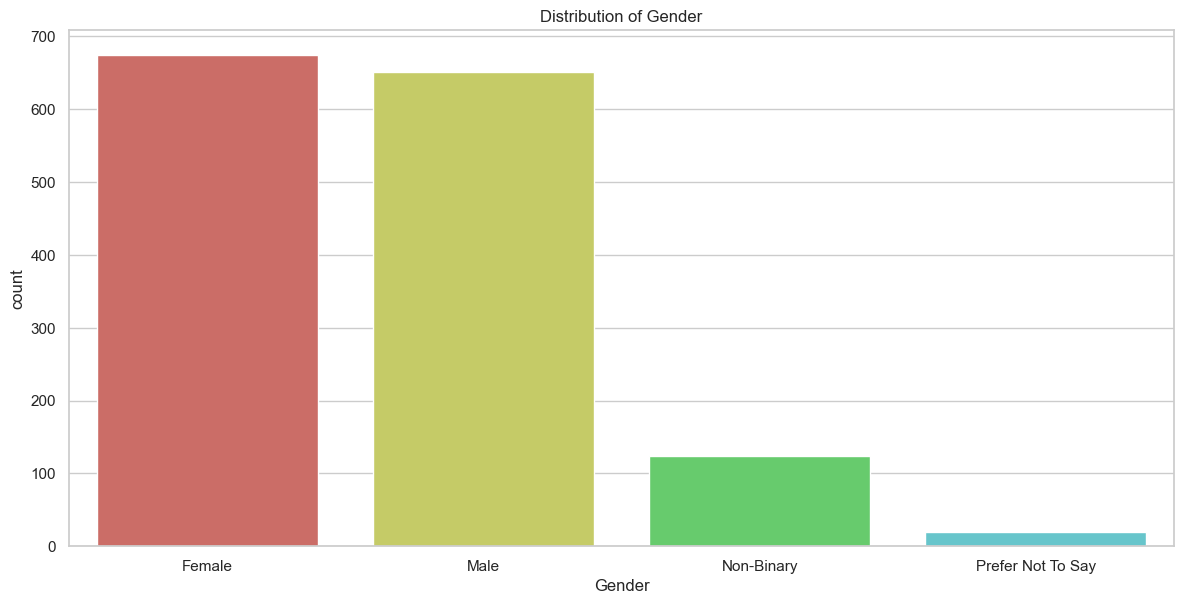

--- Categorical Summary: Gender ---
                   Count  Percentages
Female               675        45.92
Male                 651        44.29
Non-Binary           124         8.44
Prefer Not To Say     20         1.36
Unique categories: 4
Most frequent: Female


In [54]:
sns.set(style='whitegrid', palette='hls')

df = df_hr_only
plt.figure(figsize=(12, 6))
sns.countplot(x='Gender', data=df)
plt.tight_layout()
plt.title('Distribution of Gender')
plt.show()

counts = df['Gender'].value_counts(dropna=False)
percentages = df['Gender'].value_counts(normalize=True, dropna=False) * 100
print("--- Categorical Summary: Gender ---")
summary = pd.DataFrame({
    'Count' : counts,
    'Percentages': percentages.round(2)
})
print(summary)
print(f"Unique categories: {df['Gender'].nunique(dropna=False)}")
print(f"Most frequent: {df['Gender'].mode()[0]}")

Combined, 90.21% of the company identify as either **Female** or **Male**, with the most frequent gender being **Female** at 45.92%. Only 20 employees out of 1470 selected "Prefer Not To Say", making it the least frequent category. 

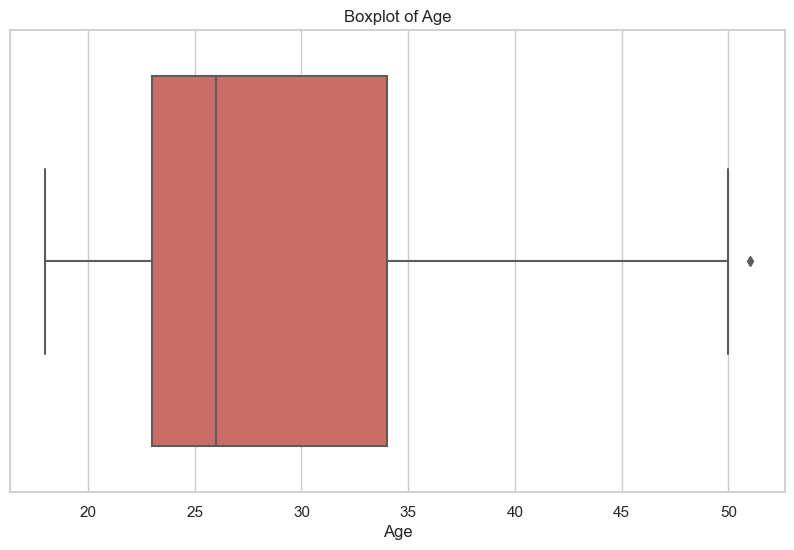

--- Numerical Summary: Age ---
count    1470.000000
mean       28.989796
std         7.993055
min        18.000000
25%        23.000000
50%        26.000000
75%        34.000000
max        51.000000
Name: Age, dtype: float64

Mode: 25
Skewness: 0.89
Kurtosis: 0.36


In [62]:
# boxplot
sns.boxplot(x=df['Age'])
plt.title("Boxplot of Age")
plt.xlabel('Age')
plt.show()

# summary
print("--- Numerical Summary: Age ---")
desc = df['Age'].describe()
print(desc)

# mode
print(f"\nMode: {df['Age'].mode()[0]}")
#skewness + kurtosis
print(f"Skewness: {skew(df['Age'].dropna()):.2f}")
print(f"Kurtosis: {kurtosis(df[col].dropna()):.2f}")


The average **age** is 28 years, with most of the employees being between 23 and 34 years old. The youngest employee is age 18, while the oldest is 51. Furthermore, the age distribution is right-skewed, with a larger concentration of younger employees. This suggest that the workforce is fairly young, with fewer employees being older than 35.

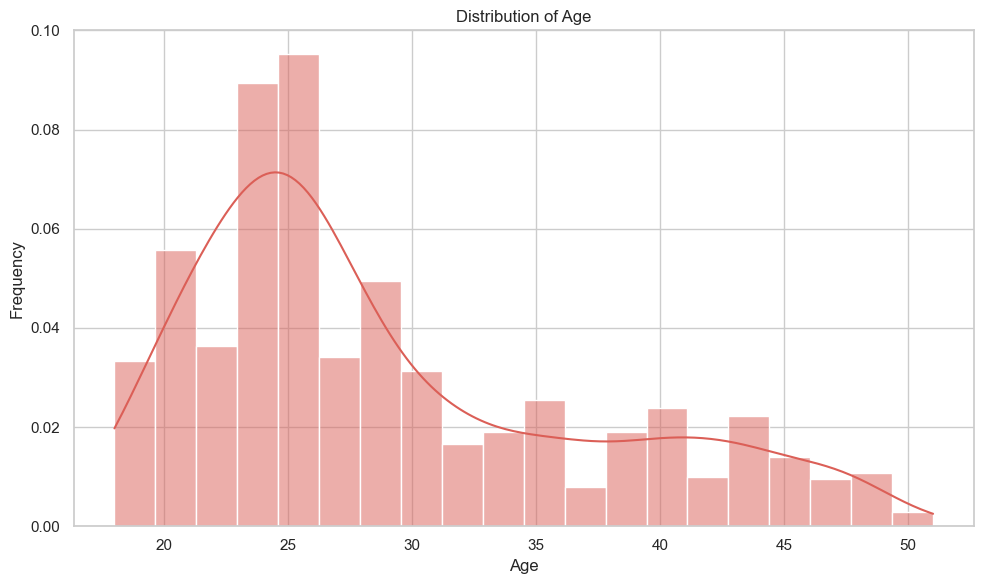


D'Agostino and Pearson Test:
Statistic = 151.4004, p-value = 0.0000
Data is not normally distributed.


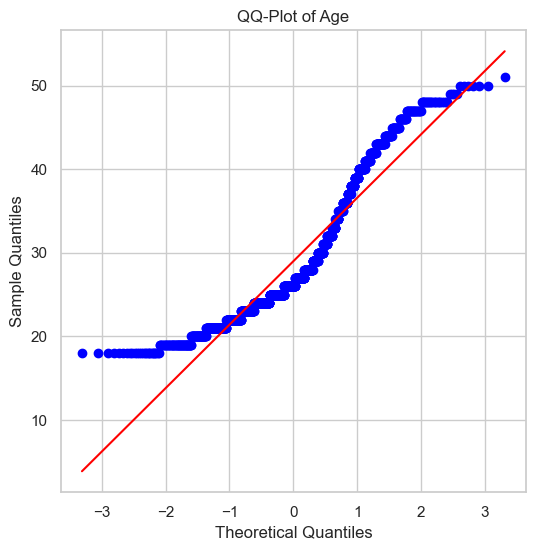

In [ ]:
# histogram + kde
sns.histplot(df['Age'], kde=True, stat='density', bins=20)
plt.title("Distribution of Age")
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# normality test
stat, p=normaltest(df['Age'])
print(f"\nD'Agostino and Pearson Test:")
print(f"Statistic = {stat:.4f}, p-value = {p:.4f}")
if p < 0.05: # 95% confidence
    print("Data is not normally distributed.")
else:
    print("Data is normally distributed.")

# QQ plot
plt.figure(figsize=(6,6))
probplot(df['Age'], dist='norm', plot=plt)
plt.title("QQ-Plot of Age")
plt.xlabel("Theoretical Quantiles")
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

The histogram with KDE and the QQ plot confirm that the age distributoin deviates from normality, showing a right-skew. Most employees are concentrated around their mid-20s, with a peak just above age 25. Beyond age 30, the number of employees gradually decreases and the distribution flattens, suggesting a relatively smaller but consistent precense of older employees. This pattern coild be due to higher attrition among older employees, or it may reflect the company's preference for hiring younger talent. Further analysis of age vs attrition rates and recruitment patterns may help clarify this trend.

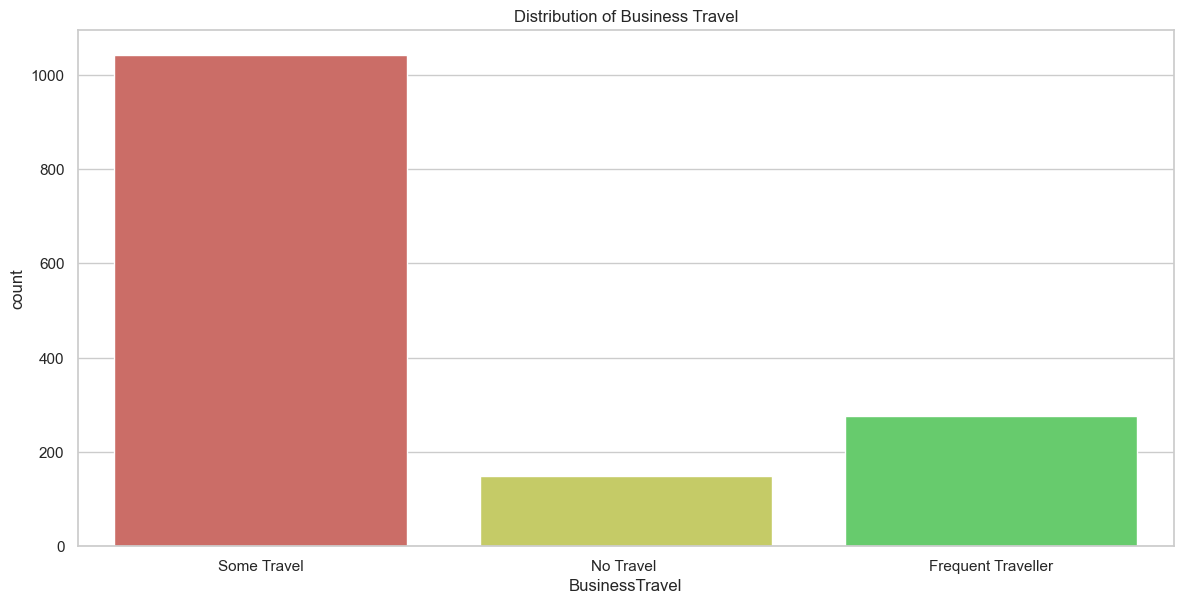


--- Categorical Summary: Business Travel ---
                    Count  Percentages
Some Travel          1043        70.95
Frequent Traveller    277        18.84
No Travel             150        10.20
Unique categories: 3
Most frequent: Some Travel


In [64]:
plt.figure(figsize=(12, 6))
sns.countplot(x='BusinessTravel', data=df)
plt.tight_layout()
plt.title('Distribution of Business Travel')
plt.show()

counts = df['BusinessTravel'].value_counts(dropna=False)
percentages = df['BusinessTravel'].value_counts(normalize=True, dropna=False) * 100
print("\n--- Categorical Summary: Business Travel ---")
summary = pd.DataFrame({
    'Count': counts,
    'Percentages': percentages.round(2)
})
print(summary)
print(f"Unique categories: {df['BusinessTravel'].nunique(dropna=False)}")
print(f"Most frequent: {df['BusinessTravel'].mode()[0]}")

The amount of business travel that is the most common is "Some Travel", at a percentage of 70.95%. The other options are "Frequent Traveler" and "No Travel", which have substantially lower counts. It can be inferred that while frequent traveling may not be required by the company, employees are still required to travel at least, a bit. For the employees who do not travel, it can be due to job role, or distance from work. However, we would need to investigate this further to see why.

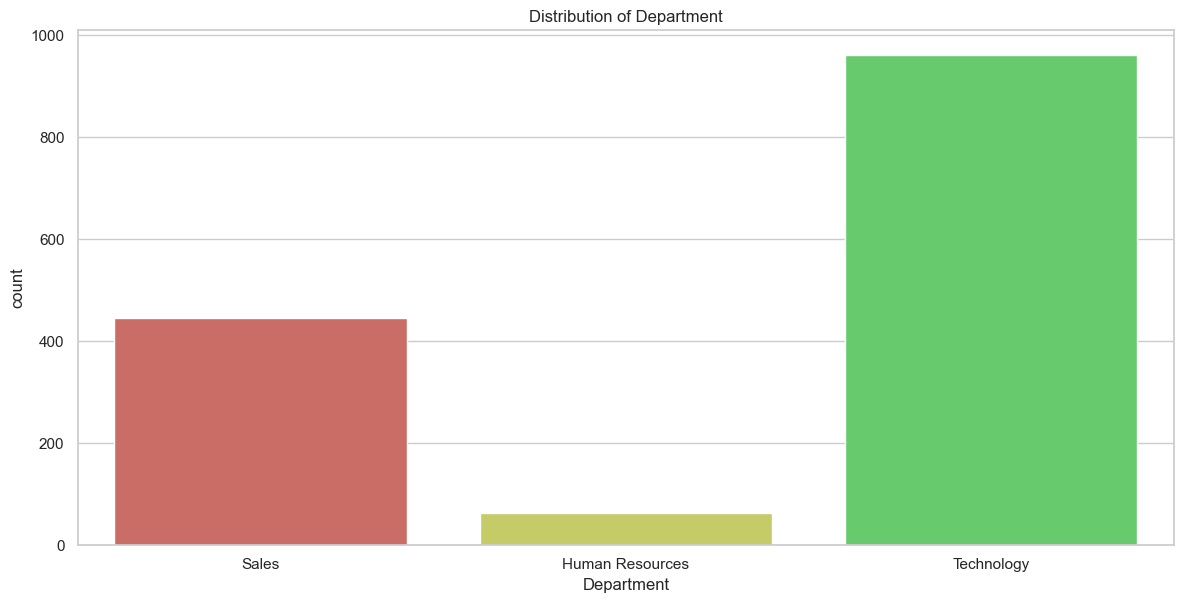


--- Categorical Summary: Department ---
                 Count  Percentages
Technology         961        65.37
Sales              446        30.34
Human Resources     63         4.29
Unique categories: 3
Most frequent: Technology


In [65]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Department', data=df)
plt.tight_layout()
plt.title('Distribution of Department')
plt.show()

counts = df['Department'].value_counts(dropna=False)
percentages = df['Department'].value_counts(normalize=True, dropna=False) * 100
print("\n--- Categorical Summary: Department ---")
summary = pd.DataFrame({
    'Count': counts,
    'Percentages': percentages.round(2)
})
print(summary)
print(f"Unique categories: {df['Department'].nunique(dropna=False)}")
print(f"Most frequent: {df['Department'].mode()[0]}")

The two most biggest departments in terms of employee size are Sales and Technology. A little more than half of employees work in Technology. About half of the employees who work in Technology, work in Sales, at 30.34%. Only 63 out of 1470 employees work in Human Resources. It can be inferred that the company mainly focuses on the Technology and Sales departments. Also related to Departments, is Education Field and Job Role. 

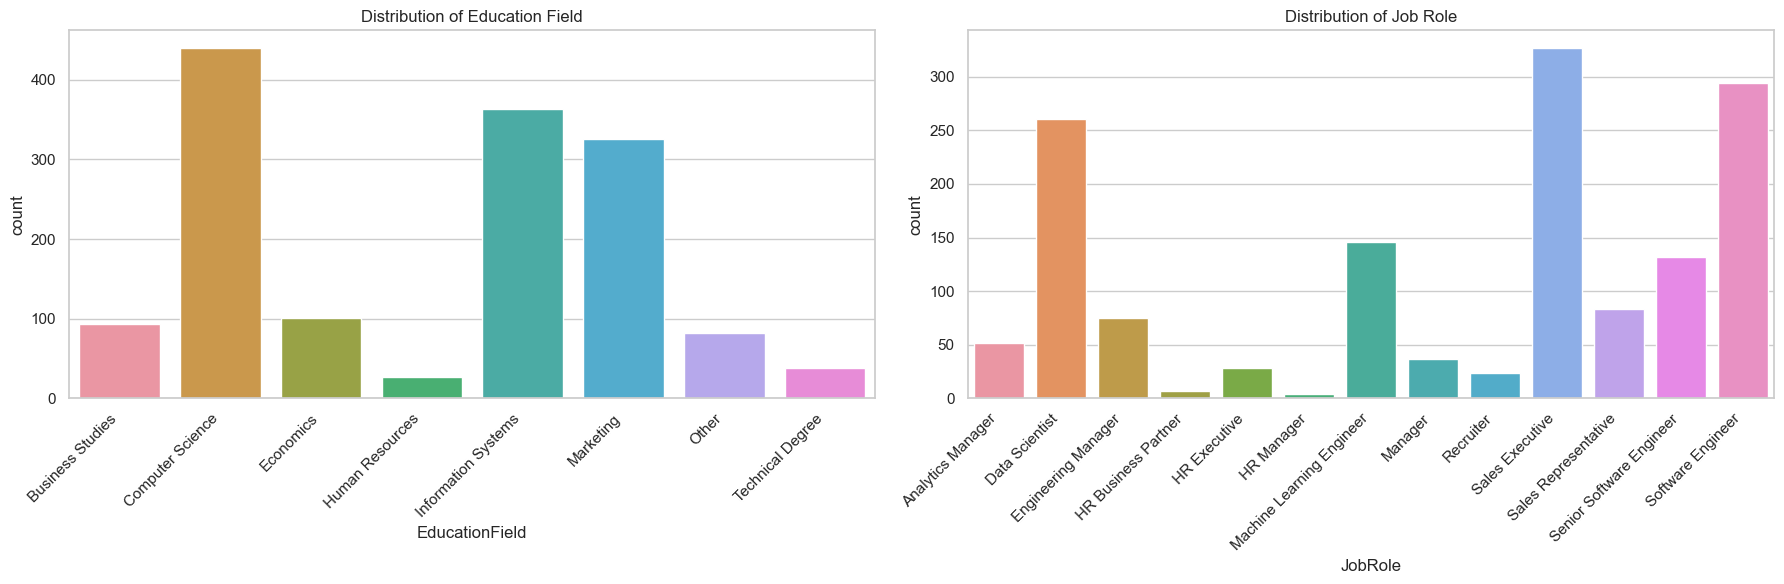


--- Categorical Summary: Education Field ---
                     Count  Percentages
Computer Science       440        29.93
Information Systems    363        24.69
Marketing              325        22.11
Economics              101         6.87
Business Studies        94         6.39
Other                   82         5.58
Technical Degree        38         2.59
Human Resources         27         1.84
Unique categories: 8
Most frequent: Computer Science

--- Categorical Summary: Job Role ---
                           Count  Percentages
Sales Executive              327        22.24
Software Engineer            294        20.00
Data Scientist               261        17.76
Machine Learning Engineer    146         9.93
Senior Software Engineer     132         8.98
Sales Representative          83         5.65
Engineering Manager           75         5.10
Analytics Manager             52         3.54
Manager                       37         2.52
HR Executive                  28         1

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.countplot(x='EducationField', data=df, ax=ax1)
ax1.set_title('Distribution of Education Field')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

sns.countplot(x='JobRole', data=df, ax=ax2)
ax2.set_title('Distribution of Job Role')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

counts = df['EducationField'].value_counts(dropna=False)
percentages = df['EducationField'].value_counts(normalize=True, dropna=False) * 100
print("\n--- Categorical Summary: Education Field ---")
summary = pd.DataFrame({
    'Count': counts,
    'Percentages': percentages.round(2)
})
print(summary)
print(f"Unique categories: {df['EducationField'].nunique(dropna=False)}")
print(f"Most frequent: {df['EducationField'].mode()[0]}")

counts = df['JobRole'].value_counts(dropna=False)
percentages = df['JobRole'].value_counts(normalize=True, dropna=False) * 100
print("\n--- Categorical Summary: Job Role ---")
summary = pd.DataFrame({
    'Count': counts,
    'Percentages': percentages.round(2)
})
print(summary)
print(f"Unique categories: {df['JobRole'].nunique(dropna=False)}")
print(f"Most frequent: {df['JobRole'].mode()[0]}")

As you can see, the most frequent Education Fields for employees are Computer Science, Information Systems, and Marketing, while the most frequent Job Roles are Sales Executive, Software Engineering, and Data Scientist.

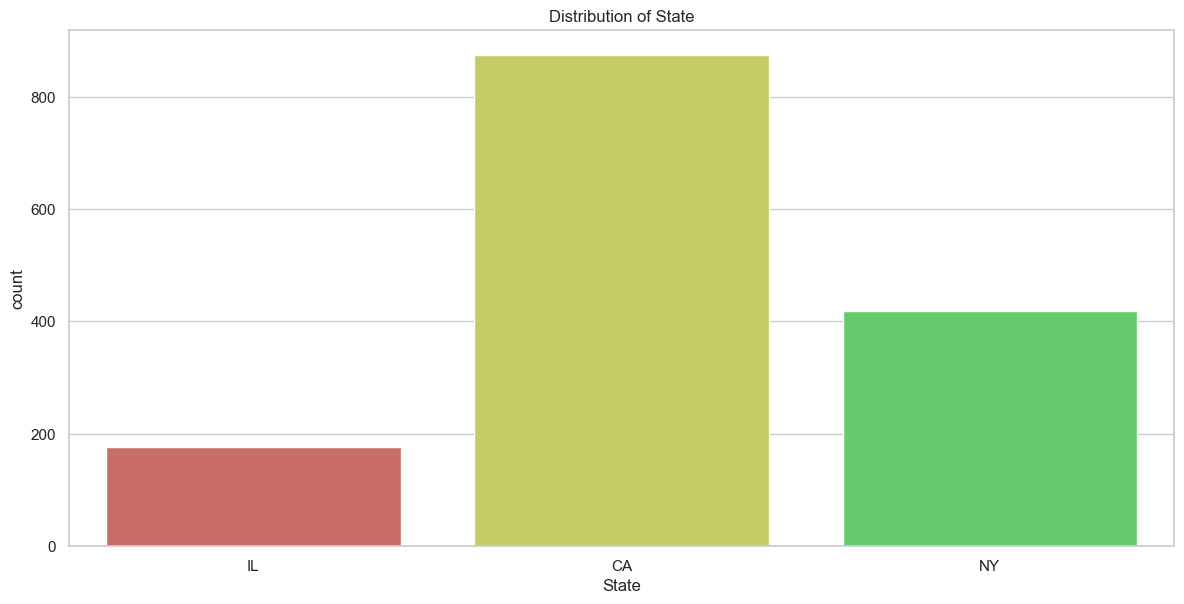


--- Categorical Summary: State ---
    Count  Percentages
CA    875        59.52
NY    419        28.50
IL    176        11.97
Unique categories: 3
Most frequent: CA


In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='State', data=df)
plt.tight_layout()
plt.title('Distribution of State')
plt.show()

counts = df['State'].value_counts(dropna=False)
percentages = df['State'].value_counts(normalize=True, dropna=False) * 100
print("\n--- Categorical Summary: State ---")
summary = pd.DataFrame({
    'Count': counts,
    'Percentages': percentages.round(2)
})
print(summary)
print(f"Unique categories: {df['State'].nunique(dropna=False)}")
print(f"Most frequent: {df['State'].mode()[0]}")

59.52% of employees reside in California, while 28.50% in New York, and 11.97% in Illnois. This could be due to smaller offices around NY and IL, while most of the company could be CA based, with their larger offices located there. Because there are only 3 states that were reported in this dataset, it suggests that this company requires employees to work onsite. If the company was mostly remote, we might see a more broader range of states in this dataset.

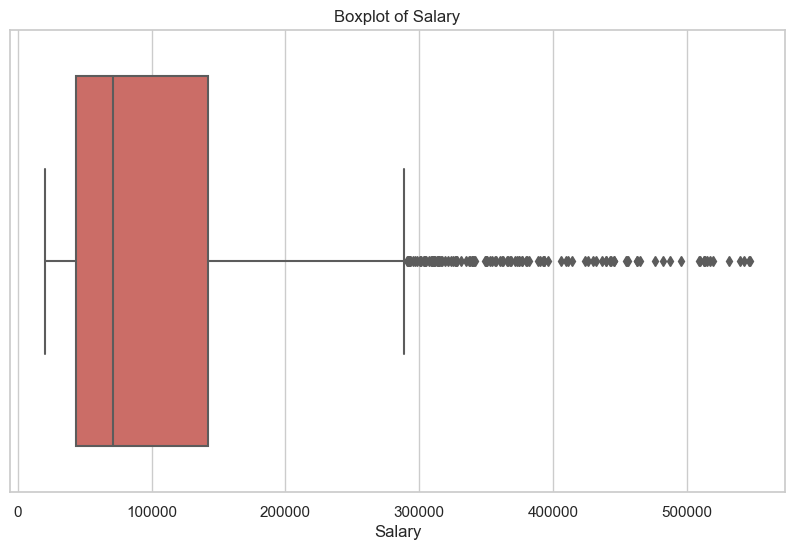

--- Numerical Summary: Salary ---
count      1470.000000
mean     112956.497959
std      103342.889222
min       20387.000000
25%       43580.500000
50%       71199.500000
75%      142055.750000
max      547204.000000
Name: Salary, dtype: float64

Mode: 26973
Skewness: 1.78
Kurtosis: 2.92


In [77]:
# boxplot
sns.boxplot(x=df['Salary'])
plt.title("Boxplot of Salary")
plt.xlabel('Salary')
plt.show()

# summary
print("--- Numerical Summary: Salary ---")
desc = df['Salary'].describe()
print(desc)

# mode
print(f"\nMode: {df['Salary'].mode()[0]}") 
# skewness + kurtosis
print(f"Skewness: {skew(df['Salary'].dropna()):.2f}")
print(f"Kurtosis: {kurtosis(df['Salary'].dropna()):.2f}")

Since the boxplot is right-skewed, we can see most of the data clustering over to the left side, meaning that most employees are paid a lower salary between $43,580 - $142,056. We also have a higher kurtosis, which can be seen by the boxplot's heavier tails with more extreme outliers. This indicates that it's extremely less common for an employee to have an extremely high salary at this company. 

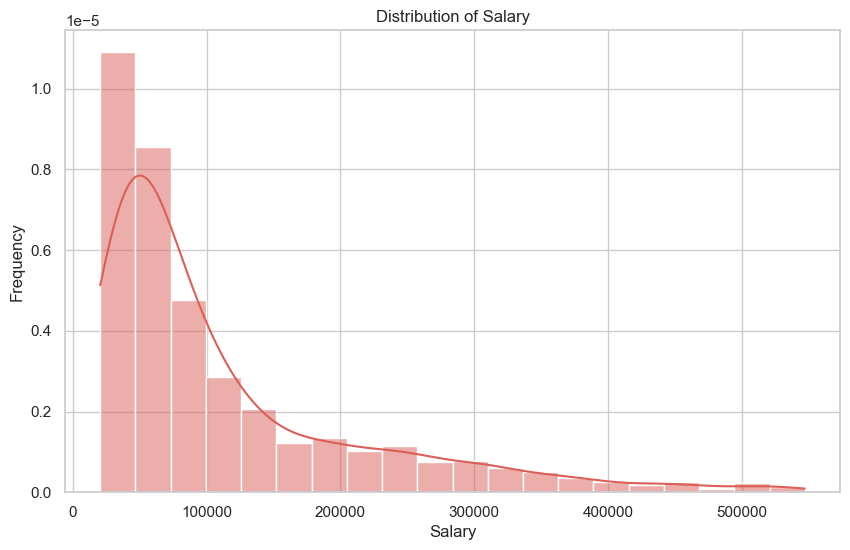


D'Agostino and Pearson Test:
Statistic = 490.7725, p-value = 0.0000
Data is not normally distributed.


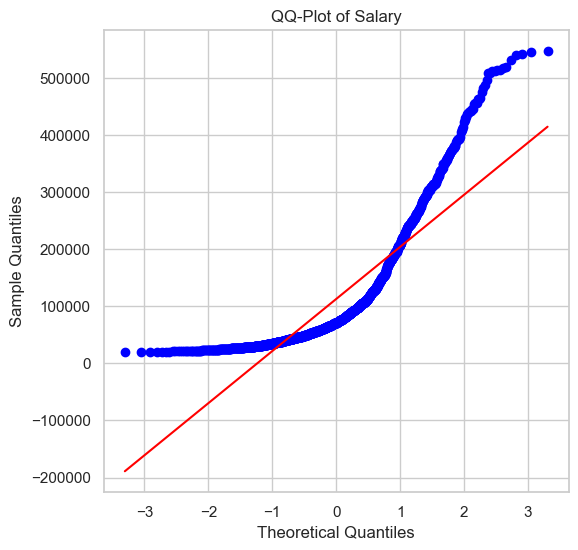

In [78]:
# histogram + kde
sns.histplot(df['Salary'], kde=True, stat='density', bins=20)
plt.title("Distribution of Salary")
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

# normality test
stat, p=normaltest(df['Salary'])
print(f"\nD'Agostino and Pearson Test:")
print(f"Statistic = {stat:.4f}, p-value = {p:.4f}")
if p < 0.05: # 95% confidence
    print("Data is not normally distributed.")
else:
    print("Data is normally distributed.")

# QQ plot
plt.figure(figsize=(6,6))
probplot(df['Salary'], dist='norm', plot=plt)
plt.title(f'QQ-Plot of Salary')
plt.xlabel("Theoretical Quantiles")
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()


Like the boxplot suggested, the histogram shows a higher density of employees that earn a lower wage, and a very long right-tail that decreases as the salary rises. It indicates that the company pays most of their employees at a lower salary wage, with rare cases of paying other employees, a higher wage.

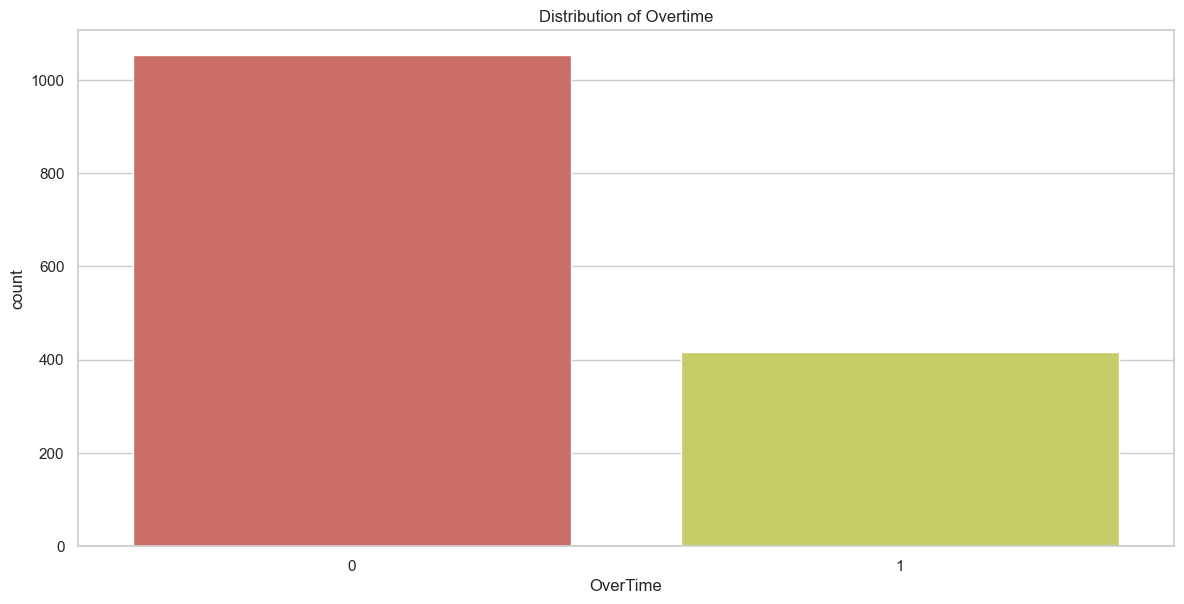


--- Categorical Summary: Overtime ---
   Count  Percentages
0   1054         71.7
1    416         28.3
Unique categories: 2
Most frequent: 0


In [81]:
plt.figure(figsize=(12, 6))
sns.countplot(x='OverTime', data=df)
plt.tight_layout()
plt.title('Distribution of Overtime')
plt.show()

counts = df['OverTime'].value_counts(dropna=False)
percentages = df['OverTime'].value_counts(normalize=True, dropna=False) * 100
print("\n--- Categorical Summary: Overtime ---")
summary = pd.DataFrame({
    'Count': counts,
    'Percentages': percentages.round(2)
})
print(summary)
print(f"Unique categories: {df['OverTime'].nunique(dropna=False)}")
print(f"Most frequent: {df['OverTime'].mode()[0]}")